#Environment Setup

Here we download and import the necessary modules and packages for data preprocessing and our stock forecasting model. We have to rollback Colab to TensorFlow version 1.x for our model to work properly. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 19.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=a6f723b61cf9d8700dc77dec0d3682a1de2a8eb6414fd0256d6eb7f8a36850a1
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
# The imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler


import tensorflow as tf
from tensorflow.keras.layers import CuDNNLSTM, Dropout,Dense,Input 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")

import os
import yfinance as yf
from datetime import date

#Collecting Data Using YFinance

We downloaded historical data from Yahoo Finance pertaining to the top 30 S&P 500 companies according to [slickcharts.com](https://www.slickcharts.com/sp500) using the YFinance API. We take historical data from as early as 2010 to the present day. In order to easily process this data, we put all the data into a dataframe. Because some companies were not public a decade ago, we merged by `outer` to capture all historical data in our time period. 

In [4]:
index = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG',' BRK-B', 'TSLA', 'NVDA', 
         'JPM', 'JNJ', 'V', 'UNH', 'PYPL', 'HD','MA', 'PG', 'DIS', 'ADBE', 'BAC',
         'CMCSA', 'XOM', 'CRM', 'VZ', 'PFE', 'NFLX', 'CSCO', 'INTC', 'KO','PEP'
         ]

start = '2010-01-01'
#Get present day
d = date.today()
end = str(d.year) + '-' + str(d.month) + '-' + str(d.day)

merged_df = pd.DataFrame(yf.download(index[0], start, end),
      index = None,)

for i in range(1,len(index)):
  t_df = yf.download(index[i], start, end)
  merged_df = pd.merge(
      merged_df,
      t_df,
      how = 'outer',
      on = 'Date',
      copy = True,
      suffixes = ('_' + index[i - 1], '_' + index[i])
  )

#Adjust the index to work with the model.
adj_month = lambda m: str(m) if m >= 10 else '0' + str(m)
adj_day = lambda d: str(d) if d >= 10 else '0' + str(d)

merged_df['Date'] = [str(k.year) + '-' + adj_month(k.month) + '-' + adj_day(k.day) for k in merged_df.index]
merged_df['Index'] = [k for k in range(merged_df.shape[0])]
merged_df.set_index('Index', inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

This is what our merged dataframe looks like.

In [5]:
merged_df

,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Adj Close_MSFT,Volume_MSFT,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Adj Close_AMZN,Volume_AMZN,Open_FB,High_FB,Low_FB,Close_FB,Adj Close_FB,Volume_FB,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Adj Close_GOOGL,Volume_GOOGL,Open_GOOG,High_GOOG,Low_GOOG,Close_GOOG,Adj Close_GOOG,Volume_GOOG,Open_ BRK-B,High_ BRK-B,Low_ BRK-B,Close_ BRK-B,...,Close_VZ,Adj Close_VZ,Volume_VZ,Open_PFE,High_PFE,Low_PFE,Close_PFE,Adj Close_PFE,Volume_PFE,Open_NFLX,High_NFLX,Low_NFLX,Close_NFLX,Adj Close_NFLX,Volume_NFLX,Open_CSCO,High_CSCO,Low_CSCO,Close_CSCO,Adj Close_CSCO,Volume_CSCO,Open_INTC,High_INTC,Low_INTC,Close_INTC,Adj Close_INTC,Volume_INTC,Open_KO,High_KO,Low_KO,Close_KO,Adj Close_KO,Volume_KO,Open_PEP,High_PEP,Low_PEP,Close_PEP,Adj Close_PEP,Volume_PEP,Date
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.622500,7.660714,7.585000,7.643214,6.572422,493729600,30.620001,31.100000,30.590000,30.950001,23.994564,38409100,136.250000,136.610001,133.139999,133.899994,133.899994,7599900,NaN,NaN,NaN,NaN,NaN,NaN,313.788788,315.070068,312.432434,313.688690,313.688690,3908488,312.304413,313.579620,310.954468,312.204773,312.204773,3927065,66.000000,66.500000,65.919998,66.220001,...,31.212946,17.960829,16176648,17.333965,17.969639,17.305504,17.960152,11.590302,54898644,7.931429,7.961429,7.565714,7.640000,7.640000,17239600,24.110001,24.840000,24.010000,24.690001,18.205612,59853700,20.790001,21.030001,20.730000,20.879999,14.773483,47800900,28.580000,28.610001,28.450001,28.520000,19.947931,13870400,61.189999,61.520000,60.639999,61.240002,43.622746,6585900,2010-01-04
1,7.664286,7.699643,7.616071,7.656429,6.583784,601904800,30.850000,31.100000,30.639999,30.959999,24.002319,49749600,133.429993,135.479996,131.809998,134.690002,134.690002,8851900,NaN,NaN,NaN,NaN,NaN,NaN,313.903900,314.234222,311.081085,312.307312,312.307312,6003391,312.418976,312.747742,309.609497,310.829926,310.829926,6031925,66.389999,66.589996,66.150002,66.540001,...,31.269218,17.993202,23722957,17.950665,17.960152,17.599621,17.703985,11.424991,45714931,7.652857,7.657143,7.258571,7.358571,7.358571,23753100,24.600000,24.730000,24.379999,24.580000,18.124498,45124500,20.940001,20.990000,20.600000,20.870001,14.766404,52357700,28.424999,28.495001,28.070000,28.174999,19.706619,23172400,61.000000,62.099998,60.900002,61.980000,44.149864,8886000,2010-01-05
2,7.656429,7.686786,7.526786,7.534643,6.479061,552160000,30.879999,31.080000,30.520000,30.770000,23.855013,58182400,134.600006,134.729996,131.649994,132.250000,132.250000,7178800,NaN,NaN,NaN,NaN,NaN,NaN,313.243256,313.243256,303.483490,304.434448,304.434448,7949443,311.761444,311.761444,302.047852,302.994293,302.994293,7987226,66.500000,66.500000,66.199997,66.199997,...,29.937416,17.475832,37506464,17.703985,17.846300,17.561670,17.647058,11.388254,43640975,7.361429,7.672857,7.197143,7.617143,7.617143,23290400,24.540001,24.740000,24.340000,24.420000,18.006519,35715700,20.809999,20.930000,20.670000,20.799999,14.716876,40037400,28.174999,28.219999,27.990000,28.165001,19.699625,19264600,61.990002,62.470001,61.230000,61.360001,43.708214,9998000,2010-01-06
3,7.562500,7.571429,7.466071,7.520714,6.467082,477131200,30.629999,30.700001,30.190001,30.450001,23.606922,50559700,132.009995,132.320007,128.800003,130.000000,130.000000,11030200,NaN,NaN,NaN,NaN,NaN,NaN,305.005005,305.305298,296.621613,297.347351,297.347351,12815771,303.562164,303.861053,295.218445,295.940735,295.940735,12876685,66.199997,66.510002,66.139999,66.459999,...,29.759218,17.371811,25508242,17.685009,17.713472,17.514231,17.580645,11.345395,41557112,7.731429,7.757143,7.462857,7.485714,7.485714,9955400,24.299999,24.570000,24.170000,24.530001,18.087631,31531200,20.730000,20.760000,20.340000,20.600000,14.575374,54041500,28.165001,28.184999,27.875000,28.094999,19.650665,13234600,61.349998,61.380001,60.529999,60.970001,43.430420,10792000,2010-01-07
4,

As we can see, there are a few columns with `NaN` data, but our model is able to work through this, so we leave our data as is. 

Here we will write a `.csv` file that contains all the companies we will be using for each year. We want to separate our stock data by `Open` and `Close` values, as well as by year. 

In [6]:
file1 = open('SPXconst.csv', 'w')

start_y = 2010
end_y = 2021

months = [str(0) + str(k+1) if k+1 < 10 else str(k+1) for k in range(12)]
years = [str(k) for k in range(start_y, end_y)]

# Date 
my_date = [m + '/' + y for y in years for m in months]

separator = ','
#Make columns and write to file
columns = separator.join(my_date)

#Features that the model will use
features = ['Open','Close']
txt = columns
#Append Indices to file.
for k in index:
  txt = txt + '\n'
  for d in my_date :
    txt += k
    if( d != my_date[-1]):
      txt += ','

file1.write(txt)
file1.close()

These variables are used to easily extract features from the merged DataFrame.

In [7]:
close_x = [k for k in merged_df.columns if k.startswith('Close_')]
open_x = [k for k in merged_df.columns if k.startswith('Open_')]
high_x = [k for k in merged_df.columns if k.startswith('High_')]
low_x = [k for k in merged_df.columns if k.startswith('Low_')]
adj_close_x = [k for k in merged_df.columns if k.startswith('Adj Close_')]
vol_x = [k for k in merged_df.columns if k.startswith('Volume_')]

##Write our data into spreadsheets for the model to read

Here we will write new `.csv` files for each year. The function defined below will parse our merged_dataframe into the format we want for our model. This function will create a `.csv` file labeled `feature-year`, where feature is either `Open` or `Close`. `Year` marks the starting year of the data. Each `.csv` contains 4 years worth of historical data starting from `year`, with the exception of the years `2019` and `2020`.

In [8]:
def make_sheets(years, index, feature, feature_x):
  for year in years:
    file1 = open(feature + '-' + str(year) + '.csv','w')

    #Write the first row to the spreadsheet
    txt = 'Date'
    for i in index:
      txt += ',' + i
    txt += '\n'
    file1.write(txt)
    file1.close()

    #Write the rest of the rows as date,index-values
    file1 = open(feature + '-' + str(year)+'.csv','a')
    for k, d in enumerate(merged_df['Date']):
      if d.startswith(year) or d.startswith(str(int(year) + 1)) or d.startswith(str(int(year) + 2)) or d.startswith(str(int(year) + 3)):
        txt = d + ','
        for v in merged_df[feature_x].loc[k]:
          if(np.isnan(v)):
            txt += ','
          else:
            txt += str(v) + ','
        txt = txt[:-1]
        txt += '\n'
        file1.write(txt)
    file1.close()

In [9]:
feature_collection = [close_x, open_x]
for i, feature in enumerate(features):
  make_sheets(years, index, feature, feature_collection[i])

#Downloading the repo

Here we download the model that our repo is from and perform some setup before we begin working with the model.

In [10]:
%%! 
git clone https://github.com/pushpendughosh/Stock-market-forecasting.git

["Cloning into 'Stock-market-forecasting'...",
 'remote: Enumerating objects: 385, done.\x1b[K',
 'remote: Counting objects:   0% (1/132)\x1b[K',
 'remote: Counting objects:   1% (2/132)\x1b[K',
 'remote: Counting objects:   2% (3/132)\x1b[K',
 'remote: Counting objects:   3% (4/132)\x1b[K',
 'remote: Counting objects:   4% (6/132)\x1b[K',
 'remote: Counting objects:   5% (7/132)\x1b[K',
 'remote: Counting objects:   6% (8/132)\x1b[K',
 'remote: Counting objects:   7% (10/132)\x1b[K',
 'remote: Counting objects:   8% (11/132)\x1b[K',
 'remote: Counting objects:   9% (12/132)\x1b[K',
 'remote: Counting objects:  10% (14/132)\x1b[K',
 'remote: Counting objects:  11% (15/132)\x1b[K',
 'remote: Counting objects:  12% (16/132)\x1b[K',
 'remote: Counting objects:  13% (18/132)\x1b[K',
 'remote: Counting objects:  14% (19/132)\x1b[K',
 'remote: Counting objects:  15% (20/132)\x1b[K',
 'remote: Counting objects:  16% (22/132)\x1b[K',
 'remote: Counting objects:  17% (23/132)\x1b[K',
 'remote: 

In [11]:
#Move Statistics.py to content folder
! mv /content/Stock-market-forecasting/Statistics.py /content

##LSTM Model

This will label our data and reshape our data further for use in our model.

In [12]:
# creates labels for the company indexes
def create_label(df_open,df_close,perc=[0.5,0.5]):
    if not np.all(df_close.iloc[:,0]==df_open.iloc[:,0]):
        print('Date Index issue')
        return
    perc = [0.]+list(np.cumsum(perc))
    label = (df_close.iloc[:,1:]/df_open.iloc[:,1:]-1).apply(
            lambda x: pd.qcut(x.rank(method='first'),perc,labels=False), axis=1)
    return label[1:]

This function will reshape our data into a form that the model can take.

In [13]:
# reshape data for model work
# returns reshaped array
def reshaper(arr):
    arr = np.array(np.split(arr,3,axis=1))
    arr = np.swapaxes(arr,0,1)
    arr = np.swapaxes(arr,1,2)
    return arr

This function will split our data into training and testing sets. Each set contains sequences of data shifted by a day for 240 days.

In [14]:
# stores the data of starting, closing, and next day
# returns the data stored in nparray for train and test
# splits data into training/testing
def create_stock_data(df_open,df_close,st,m=240):
    st_data = pd.DataFrame([])
    st_data['Date'] = list(df_close['Date'])
    st_data['Name'] = [st]*len(st_data)
    daily_change = df_close[st]/df_open[st]-1
    for k in range(m)[::-1]:
        st_data['IntraR'+str(k)] = daily_change.shift(k)

    nextday_ret = (np.array(df_open[st][1:])/np.array(df_close[st][:-1])-1)
    nextday_ret = pd.Series(list(nextday_ret)+[np.nan])     
    for k in range(m)[::-1]:
        st_data['NextR'+str(k)] = nextday_ret.shift(k)

    close_change = df_close[st].pct_change()
    for k in range(m)[::-1]:
        st_data['CloseR'+str(k)] = close_change.shift(k)

    st_data['IntraR-future'] = daily_change.shift(-1)    
    st_data['label'] = list(label[st])+[np.nan] 
    st_data['Month'] = list(df_close['Date'].str[:-3])
    st_data = st_data.dropna()
    
    trade_year = st_data['Month'].str[:4]
    st_data = st_data.drop(columns=['Month'])
    st_train_data = st_data[trade_year<str(test_year)]
    st_test_data = st_data[trade_year==str(test_year)]
    return st_train_data,st_test_data


Below is an example of how our data is split.

In [15]:
open_df = pd.read_csv('Open-2010.csv')
close_df = pd.read_csv('Close-2010.csv')
label = create_label(open_df,close_df)
test_year = '2013'

st_train_data, st_test_data = create_stock_data(open_df, close_df, 'AAPL')
st_train_data

,Date,Name,IntraR239,IntraR238,IntraR237,IntraR236,IntraR235,IntraR234,IntraR233,IntraR232,IntraR231,IntraR230,IntraR229,IntraR228,IntraR227,IntraR226,IntraR225,IntraR224,IntraR223,IntraR222,IntraR221,IntraR220,IntraR219,IntraR218,IntraR217,IntraR216,IntraR215,IntraR214,IntraR213,IntraR212,IntraR211,IntraR210,IntraR209,IntraR208,IntraR207,IntraR206,IntraR205,IntraR204,IntraR203,IntraR202,...,CloseR37,CloseR36,CloseR35,CloseR34,CloseR33,CloseR32,CloseR31,CloseR30,CloseR29,CloseR28,CloseR27,CloseR26,CloseR25,CloseR24,CloseR23,CloseR22,CloseR21,CloseR20,CloseR19,CloseR18,CloseR17,CloseR16,CloseR15,CloseR14,CloseR13,CloseR12,CloseR11,CloseR10,CloseR9,CloseR8,CloseR7,CloseR6,CloseR5,CloseR4,CloseR3,CloseR2,CloseR1,CloseR0,IntraR-future,label
240,2010-12-15,AAPL,0.001026,0.016163,0.005556,-0.007925,0.012803,0.007077,-0.013197,0.003247,0.024280,-0.031203,0.015019,0.019272,0.045664,-0.002758,0.000049,-0.004955,0.028301,0.046965,-0.012119,0.000255,-0.020378,0.024369,-0.014479,0.008088,0.001172,0.003946,-0.019077,-0.011329,-0.007178,0.008097,-0.006406,0.000942,0.009580,0.014919,-0.012110,-0.022871,-0.010947,-0.015503,...,-0.010533,0.000065,-0.007182,0.002542,0.000975,-0.012080,-0.006607,0.015816,0.014234,0.013103,0.008052,-0.002484,0.012137,-0.013736,-0.005179,0.003175,-0.023861,-0.008883,-0.014785,0.013280,0.009076,-0.004189,0.012293,0.004993,0.005577,0.005610,-0.006212,0.005518,0.007168,-0.001638,0.005142,0.016194,-0.012878,0.007822,-0.007699,0.014766,-0.008139,-0.005377,-0.000498,1.0
241,2010-12-16,AAPL,0.016163,0.005556,-0.007925,0.012803,0.007077,-0.013197,0.003247,0.024280,-0.031203,0.015019,0.019272,0.045664,-0.002758,0.000049,-0.004955,0.028301,0.046965,-0.012119,0.000255,-0.020378,0.024369,-0.014479,0.008088,0.001172,0.003946,-0.019077,-0.011329,-0.007178,0.008097,-0.006406,0.000942,0.009580,0.014919,-0.012110,-0.022871,-0.010947,-0.015503,0.005171,...,0.000065,-0.007182,0.002542,0.000975,-0.012080,-0.006607,0.015816,0.014234,0.013103,0.008052,-0.002484,0.012137,-0.013736,-0.005179,0.003175,-0.023861,-0.008883,-0.014785,0.013280,0.009076,-0.004189,0.012293,0.004993,0.005577,0.005610,-0.006212,0.005518,0.007168,-0.001638,0.005142,0.016194,-0.012878,0.007822,-0.007699,0.014766,-0.008139,-0.005377,0.003406,0.003181,1.0
242,2010-12-17,AAPL,0.005556,-0.007925,0.012803,0.007077,-0.013197,0.003247,0.024280,-0.031203,0.015019,0.019272,0.045664,-0.002758,0.000049,-0.004955,0.028301,0.046965,-0.012119,0.000255,-0.020378,0.024369,-0.014479,0.008088,0.001172,0.003946,-0.019077,-0.011329,-0.007178,0.008097,-0.006406,0.000942,0.009580,0.014919,-0.012110,-0.022871,-0.010947,-0.015503,0.005171,-0.001863,...,-0.007182,0.002542,0.000975,-0.012080,-0.006607,0.015816,0.014234,0.013103,0.008052,-0.002484,0.012137,-0.013736,-0.005179,0.003175,-0.023861,-0.008883,-0.014785,0.013280,0.009076,-0.004189,0.012293,0.004993,0.005577,0.005610,-0.006212,0.005518,0.007168,-0.001638,0.005142,0.016194,-0.012878,0.007822,-0.007699,0.014766,-0.008139,-0.005377,0.003406,0.001682,-0.001893,0.0
243,2010-12-20,AAPL,-0.007925,0.012803,0.007077,-0.013197,0.003247,0.024280,-0.031203,0.015019,0.019272,0.045664,-0.002758,0.000049,-0.004955,0.028301,0.046965,-0.012119,0.000255,-0.020378,0.024369,-0.014479,0.008088,0.001172,0.003946,-0.019077,-0.011329,-0.007178,0.008097,-0.006406,0.000942,0.009580,0.014919,-0.012110,-0.022871,-0.010947,-0.015503,0.005171,-0.001863,-0.006786,...,0.002542,0.000975,-0.012080,-0.006607,0.015816,0.014234,0.013103,0.008052,-0.002484,0.012137,-0.013736,-0.005179,0.003175,-0.023861,-0.008883,-0.014785,0.013280,0.009076,-0.004189,0.012293,0.004993,0.005577,0.005610,-0.006212,0.005518,0.007168,-0.001638,0.005142,0.016194,-0.012878,0.007822,-0.007699,0.014766,-0.008139,-0.005377,0.003406,0.001682,-0.000093,-0.003701,1.0
244,2010-12-21,AAPL,0.012803,0.007077,-0.013197,0.003247,0.024280,-0.031203,0.015019,0.019272,0.045664,-0.002758,0.000049,-0.004955,0.028301,0.046965,-0.012119,0.000255,-0.020378,0.024369,-0.014479,0.008088,0.001172,0.003946,-0.019077

In [16]:
st_test_data[:-2]

,Date,Name,IntraR239,IntraR238,IntraR237,IntraR236,IntraR235,IntraR234,IntraR233,IntraR232,IntraR231,IntraR230,IntraR229,IntraR228,IntraR227,IntraR226,IntraR225,IntraR224,IntraR223,IntraR222,IntraR221,IntraR220,IntraR219,IntraR218,IntraR217,IntraR216,IntraR215,IntraR214,IntraR213,IntraR212,IntraR211,IntraR210,IntraR209,IntraR208,IntraR207,IntraR206,IntraR205,IntraR204,IntraR203,IntraR202,...,CloseR37,CloseR36,CloseR35,CloseR34,CloseR33,CloseR32,CloseR31,CloseR30,CloseR29,CloseR28,CloseR27,CloseR26,CloseR25,CloseR24,CloseR23,CloseR22,CloseR21,CloseR20,CloseR19,CloseR18,CloseR17,CloseR16,CloseR15,CloseR14,CloseR13,CloseR12,CloseR11,CloseR10,CloseR9,CloseR8,CloseR7,CloseR6,CloseR5,CloseR4,CloseR3,CloseR2,CloseR1,CloseR0,IntraR-future,label
754,2013-01-02,AAPL,0.005611,0.017107,-0.011090,0.011156,0.017418,0.008389,-0.006573,-0.016114,-0.001950,0.004866,0.001714,-0.005177,-0.012048,-0.007636,-0.012965,-0.025164,-0.004986,-0.006108,-0.009422,0.033335,-0.021326,0.001972,-0.015480,0.000078,-0.002537,-0.005245,-0.008464,-0.013915,-0.001622,0.006796,-0.001724,0.022995,-0.012447,0.011513,-0.013469,-0.001761,-0.005471,-0.018588,...,-0.027769,-0.023020,-0.036049,0.025406,-0.027502,0.012228,-0.014610,-0.022938,0.029532,0.057702,-0.013394,0.005175,0.015392,0.023702,-0.020829,0.022433,-0.005811,0.011691,-0.019961,-0.022155,-0.070257,0.046243,-0.051319,0.028133,0.014821,-0.030341,-0.030876,-0.011306,0.031576,0.012324,-0.002766,-0.033075,0.015377,-0.002594,-0.010520,-0.006329,0.000470,0.084794,0.010662,1.0
755,2013-01-03,AAPL,0.017107,-0.011090,0.011156,0.017418,0.008389,-0.006573,-0.016114,-0.001950,0.004866,0.001714,-0.005177,-0.012048,-0.007636,-0.012965,-0.025164,-0.004986,-0.006108,-0.009422,0.033335,-0.021326,0.001972,-0.015480,0.000078,-0.002537,-0.005245,-0.008464,-0.013915,-0.001622,0.006796,-0.001724,0.022995,-0.012447,0.011513,-0.013469,-0.001761,-0.005471,-0.018588,-0.019556,...,-0.023020,-0.036049,0.025406,-0.027502,0.012228,-0.014610,-0.022938,0.029532,0.057702,-0.013394,0.005175,0.015392,0.023702,-0.020829,0.022433,-0.005811,0.011691,-0.019961,-0.022155,-0.070257,0.046243,-0.051319,0.028133,0.014821,-0.030341,-0.030876,-0.011306,0.031576,0.012324,-0.002766,-0.033075,0.015377,-0.002594,-0.010520,-0.006329,0.000470,0.084794,-0.010726,0.018918,1.0
756,2013-01-04,AAPL,-0.011090,0.011156,0.017418,0.008389,-0.006573,-0.016114,-0.001950,0.004866,0.001714,-0.005177,-0.012048,-0.007636,-0.012965,-0.025164,-0.004986,-0.006108,-0.009422,0.033335,-0.021326,0.001972,-0.015480,0.000078,-0.002537,-0.005245,-0.008464,-0.013915,-0.001622,0.006796,-0.001724,0.022995,-0.012447,0.011513,-0.013469,-0.001761,-0.005471,-0.018588,-0.019556,0.023994,...,-0.036049,0.025406,-0.027502,0.012228,-0.014610,-0.022938,0.029532,0.057702,-0.013394,0.005175,0.015392,0.023702,-0.020829,0.022433,-0.005811,0.011691,-0.019961,-0.022155,-0.070257,0.046243,-0.051319,0.028133,0.014821,-0.030341,-0.030876,-0.011306,0.031576,0.012324,-0.002766,-0.033075,0.015377,-0.002594,-0.010520,-0.006329,0.000470,0.084794,-0.010726,-0.019913,-0.003627,0.0
757,2013-01-07,AAPL,0.011156,0.017418,0.008389,-0.006573,-0.016114,-0.001950,0.004866,0.001714,-0.005177,-0.012048,-0.007636,-0.012965,-0.025164,-0.004986,-0.006108,-0.009422,0.033335,-0.021326,0.001972,-0.015480,0.000078,-0.002537,-0.005245,-0.008464,-0.013915,-0.001622,0.006796,-0.001724,0.022995,-0.012447,0.011513,-0.013469,-0.001761,-0.005471,-0.018588,-0.019556,0.023994,-0.001452,...,0.025406,-0.027502,0.012228,-0.014610,-0.022938,0.029532,0.057702,-0.013394,0.005175,0.015392,0.023702,-0.020829,0.022433,-0.005811,0.011691,-0.019961,-0.022155,-0.070257,0.046243,-0.051319,0.028133,0.014821,-0.030341,-0.030876,-0.011306,0.031576,0.012324,-0.002766,-0.033075,0.015377,-0.002594,-0.010520,-0.006329,0.000470,0.084794,-0.010726,-0.019913,-0.027879,0.007424,1.0
758,2013-01-08,AAPL,0.017418,0.008389,-0.006573,-0.016114,-0.001950,0.004866,0.001714,-0.005177,-0.012048,-0.007636,-0.012965,-0.025164,-0.004986,-0.006108,-0.009422,0.033335,-0.021

As we can see, our data has the first days returns in `IntraR239`. The next column, `IntraR238` is shifted by 1 day and so on.

This function will scale our data to prevent look-ahead bias and for use in our metrics, specifically the Sharpe ratio. This metric doesn't work well on non-normally distributed data.

In [17]:
# normalizes the data
# returns train/test data normalized
def scalar_normalize(train_data,test_data):
    scaler = RobustScaler()
    scaler.fit(train_data[:,2:-2])
    train_data[:,2:-2] = scaler.transform(train_data[:,2:-2])
    test_data[:,2:-2] = scaler.transform(test_data[:,2:-2]) 

This function will create the LSTM model that will be used. The model architecture is as follows:

1. Input layer
1. CuDNNLSTM layer
1. Dropout layer (10%)
1. Dense layer

In [18]:
# creates and compiles the LSTM model (from tensorflow.keras)
# returns model
def makeLSTM():
    inputs = Input(shape=(240,3))
    x = CuDNNLSTM(25,return_sequences=False)(inputs)
    x = Dropout(0.1)(x)
    outputs = Dense(2,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(),
                          metrics=['accuracy'])
    model.summary()
    return model

The callbacks are defined here to save checkpoints for our model and stop training early to prevent overfitting.

In [19]:
# callbacks for early stopping of the model
def callbacks_req(model_type='LSTM'):
    csv_logger = CSVLogger(model_folder+'/training-log-'+model_type+'-'+str(test_year)+'.csv')
    filepath = model_folder+"/model-" + model_type + '-' + str(test_year) + "-E{epoch:02d}.h5"
    # model_checkpoint = [ModelCheckpoint(filepath, monitor='val_loss',save_best_only=False, period=1),
    #                     ModelCheckpoint(filepath, monitor='accuracy', save_best_only = True, period = 1)
    model_checkpoint = ModelCheckpoint(filepath, monitor='acc', save_best_only = True, period = 1)
    earlyStopping = EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True)
    return [csv_logger,earlyStopping,model_checkpoint]

This function will train the model and perform predictions on our data. 

In [20]:
def trainer(train_data,test_data):
    np.random.shuffle(train_data)
    train_x,train_y,train_ret = train_data[:,2:-2],train_data[:,-1],train_data[:,-2]
    train_x = reshaper(train_x)
    train_y = np.reshape(train_y,(-1, 1))
    train_ret = np.reshape(train_ret,(-1, 1))
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(train_y)
    enc_y = enc.transform(train_y).toarray()
    train_ret = np.hstack((np.zeros((len(train_data),1)),train_ret)) 

    model = makeLSTM()
    callbacks = callbacks_req()
    hist = model.fit(train_x,
              enc_y,
              epochs=1000,
              validation_split=0.2,
              callbacks=callbacks,
              batch_size=512
              )

    dates = list(set(test_data[:,0]))
    predictions = {}
    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = reshaper(test_d[:,2:-2])
        predictions[day] = model.predict(test_d)[:,1]
    return model,predictions, hist

This function will use our predictions to determine the top 10 and flop 10 stocks in our dataset. Then, it will return the mean returns of each respectively.

In [21]:
# further predictions by simulating day to day
# finds highs and lows of data
def simulate(test_data,predictions):
    rets = pd.DataFrame([],columns=['Long','Short'])
    k = 10
    for day in sorted(predictions.keys()):
        preds = predictions[day]
        test_returns = test_data[test_data[:,0]==day][:,-2]
        top_preds = predictions[day].argsort()[-k:][::-1] 
        trans_long = test_returns[top_preds]
        worst_preds = predictions[day].argsort()[:k][::-1] 
        trans_short = -test_returns[worst_preds]
        rets.loc[day] = [np.mean(trans_long),np.mean(trans_short)] 
    print('Result : ',rets.mean())
    return rets

The following code blocks will perform model specific preprocessing, training and simulation.

In [22]:
from Statistics import Statistics

SEED = 9
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# os.chdir('/content')

# Stock data
st_data = pd.DataFrame()

# indices of the S&P 500 companies, stored by month in the csv file
SP500_df = pd.read_csv('SPXconst.csv')
all_companies = sorted(list(set(SP500_df.values.flatten())))

# stores company index / name
constituents = {'-'.join(col.split('/')[::-1]):set(SP500_df[col].dropna()) 
                for col in SP500_df.columns}

# finds the company index that is in the train data
constituents_train = {} 
for test_year in range(start_y + 3,end_y):
    months = [str(t)+'-0'+str(m) if m<10 else str(t)+'-'+str(m) 
              for t in range(test_year-3,test_year) for m in range(1,13)]
    constituents_train[test_year] = [list(constituents[m]) for m in months]
    constituents_train[test_year] = set([i for sublist in constituents_train[test_year] 
                                         for i in sublist])

In [23]:
# stores the training model and results
# logs training in a .csv file for easy viewing  
model_folder = 'models-Intraday-240-3-LSTM'
result_folder = 'results-Intraday-240-3-LSTM'

for directory in [model_folder,result_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [24]:
hist_dict = {k: {} for k in range(2013,2021)}

In [25]:
# main loop for running model over our data
for test_year in range(start_y + 3, end_y):

    print('-'*40)
    print(test_year)
    print('-'*40)
    
    # opens data files
    # can change to be years closer to target prediction year
    filename = 'Open-'+str(test_year-3)+'.csv'
    df_open = pd.read_csv(filename)
    filename = 'Close-'+str(test_year-3)+'.csv'
    df_close = pd.read_csv(filename)
    
    # creates the labels, stock names, and test/train data from our csv files
    label = create_label(df_open,df_close)
    stock_names = list(constituents[str(test_year-1)+'-12'])
    train_data,test_data = [],[]

    start = time.time()
    for st in stock_names:
        st_train_data,st_test_data = create_stock_data(df_open,df_close,st)
        train_data.append(np.array(st_train_data))
        test_data.append(np.array(st_test_data))
    
    train_data = np.concatenate([x for x in train_data])
    test_data = np.concatenate([x for x in test_data])
        
    scalar_normalize(train_data,test_data)
    print(train_data.shape,test_data.shape,time.time()-start)
    
    # gets predictions 
    # also stores predictions (long and short) in a csv file
    model,predictions,hist = trainer(train_data,test_data)
    returns = simulate(test_data,predictions)
    returns.to_csv(result_folder+'/avg_daily_rets-'+str(test_year)+'.csv')
    
    # writes report
    # includes: Mean, Sharpe, StDev
    result = Statistics(returns.sum(axis=1))
    print('\nAverage returns prior to transaction charges')
    result.shortreport() 
    
    #Write mode for our results text file
    if test_year == 2013:
      file_mode = "w"
    else:
      file_mode = "a"

    with open(result_folder+"/avg_returns.txt", file_mode) as myfile:
        res = '-'*30 + '\n'
        res += str(test_year) + '\n'
        res += 'Mean = ' + str(result.mean()) + '\n'
        res += 'Sharpe = '+str(result.sharpe()) + '\n'
        res += '-'*30 + '\n'
        myfile.write(res)      


    ###Saving the model for use later
    LSTM_folder = 'saved-model-Intraday-240-3-LSTM-' + str(test_year)
    print('Saving model...')
    if not os.path.exists(LSTM_folder):
        os.makedirs(LSTM_folder)
    tf.saved_model.save(model, '/content/' + LSTM_folder)

    #Here we will save 
    print(hist.history.keys)
    hist_dict[test_year] = hist.history

----------------------------------------
2013
----------------------------------------
(14270, 724) (7194, 724) 14.521773099899292
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 3)]          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 25)                3000      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 52        
Total params: 3,052
Trainable params: 3,052
Non-trainable params: 0
_________________________________________________________________
Train on 11416 samples, validate on 2854 samp

Here we do extra training models for the current year 2021

In [26]:
open_df = pd.read_csv('Open-2018.csv')
close_df = pd.read_csv('Close-2018.csv')
test_year = 2021

label = create_label(open_df,close_df)

In [27]:
train, test = [],[]

for s in index:
  st_train, st_test = create_stock_data(open_df, close_df ,s)
  train.append(st_train)
  test.append(st_test)

train = np.concatenate([x for x in train])
test = np.concatenate([x for x in test])

scalar_normalize(train,test)

In [28]:
model, predictions_LSTM, hist = trainer(train, test)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 240, 3)]          0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 25)                3000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 52        
Total params: 3,052
Trainable params: 3,052
Non-trainable params: 0
_________________________________________________________________
Train on 12384 samples, validate on 3096 samples
Epoch 1/1000
12384/12384 [==============================] - 7s 605us/sample - loss: 0.6747 - acc: 0.6357 - val_loss: 0.6624 - val_acc: 0.6789
Epoch 2/1000
12384/12384 [==============================] - 2s 1

In [29]:
###Saving the model for use later
LSTM_folder = 'saved-model-Intraday-240-3-LSTM-' + str(test_year)
print('Saving model...')
if not os.path.exists(LSTM_folder):
  ###Saving the model for use later
    LSTM_folder = 'saved-model-Intraday-240-3-LSTM-' + str(test_year)
    print('Saving model...')
    if not os.path.exists(LSTM_folder):
        os.makedirs(LSTM_folder)
    tf.saved_model.save(model, '/content/' + LSTM_folder)###Saving the model for use later
    LSTM_folder = 'saved-model-Intraday-240-3-LSTM-' + str(test_year)
    print('Saving model...')
    if not os.path.exists(LSTM_folder):
        os.makedirs(LSTM_folder)
    tf.saved_model.save(model, '/content/' + LSTM_folder)
    try:
      os.makedirs(LSTM_folder)
    except:
      print("Directory Exists")
tf.saved_model.save(model, '/content/' + LSTM_folder)

hist_dict[test_year] = hist.history

Saving model...
Saving model...
INFO:tensorflow:Assets written to: /content/saved-model-Intraday-240-3-LSTM-2021/assets
Saving model...
INFO:tensorflow:Assets written to: /content/saved-model-Intraday-240-3-LSTM-2021/assets
Directory Exists
INFO:tensorflow:Assets written to: /content/saved-model-Intraday-240-3-LSTM-2021/assets


###Model Performance Graphs

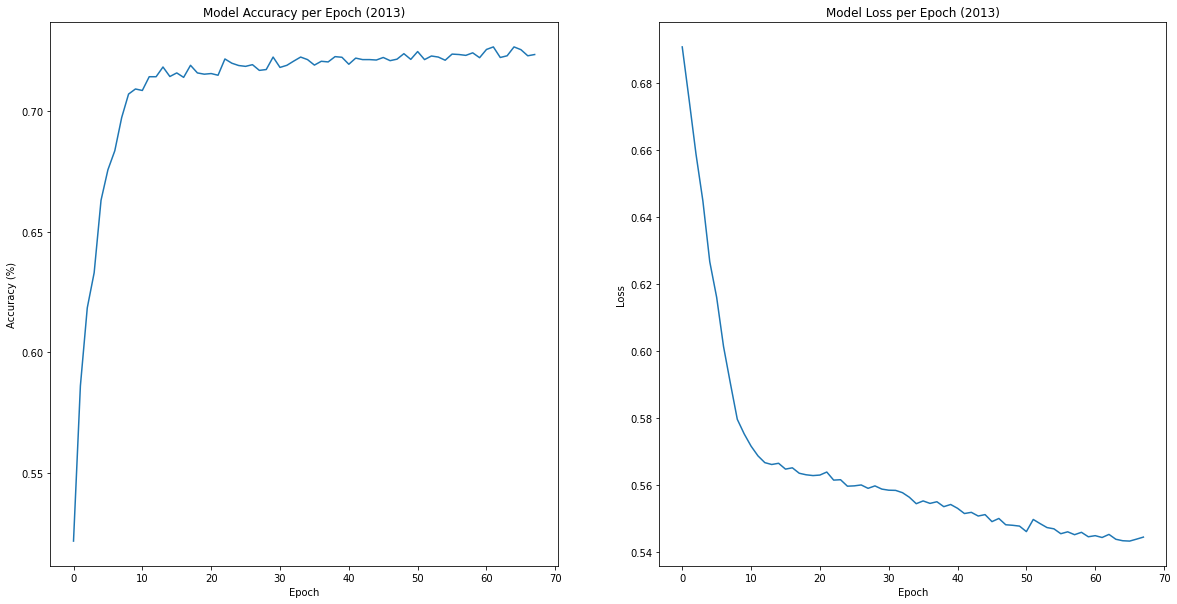

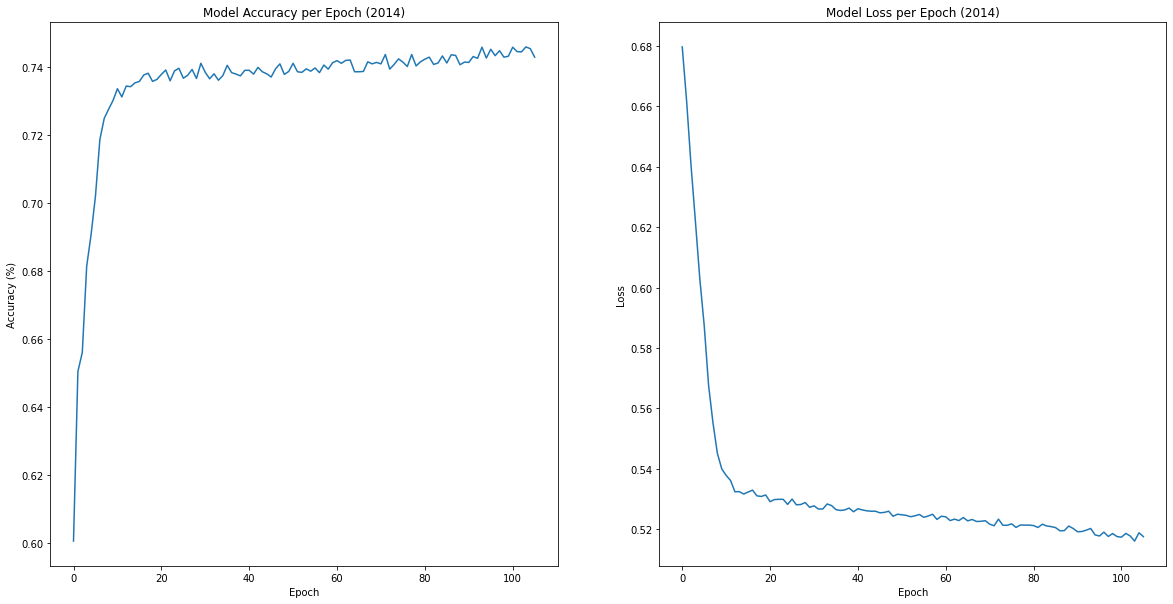

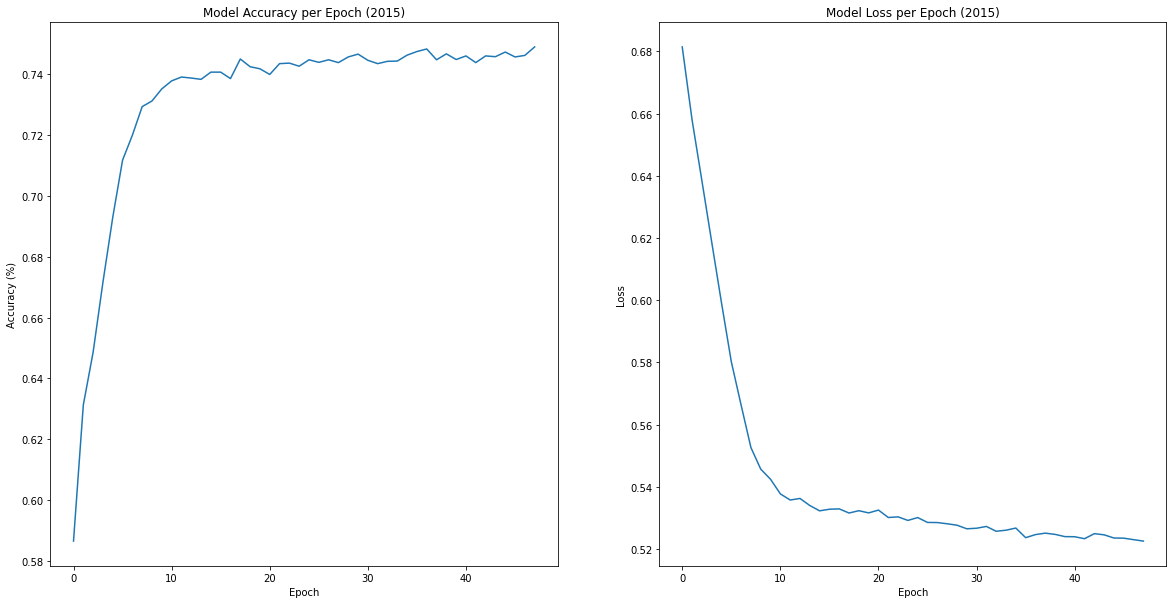

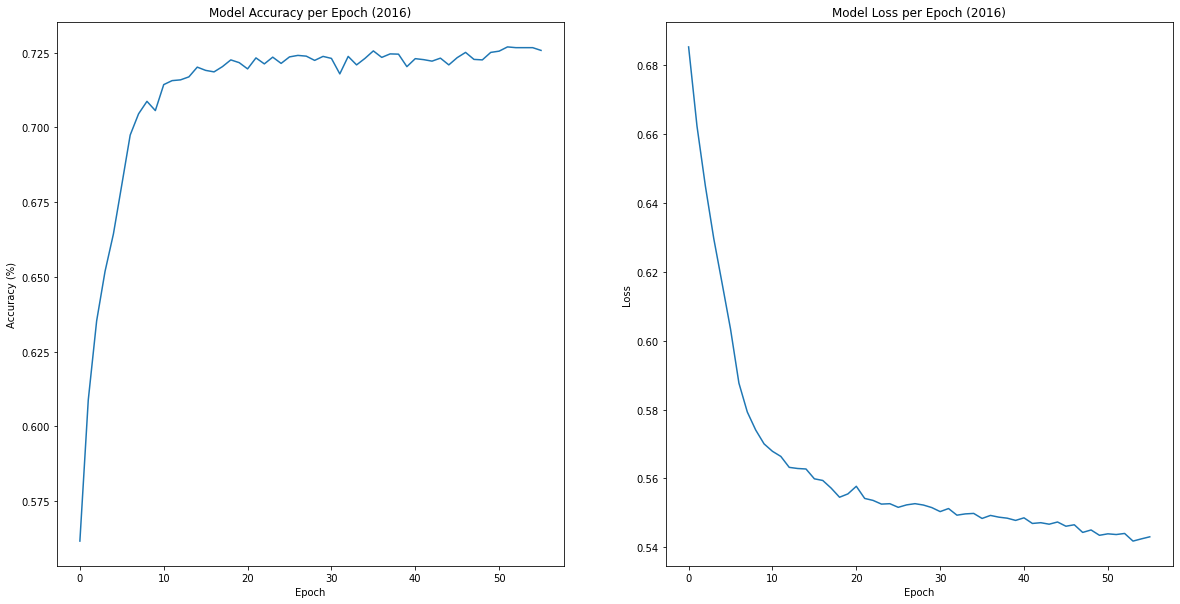

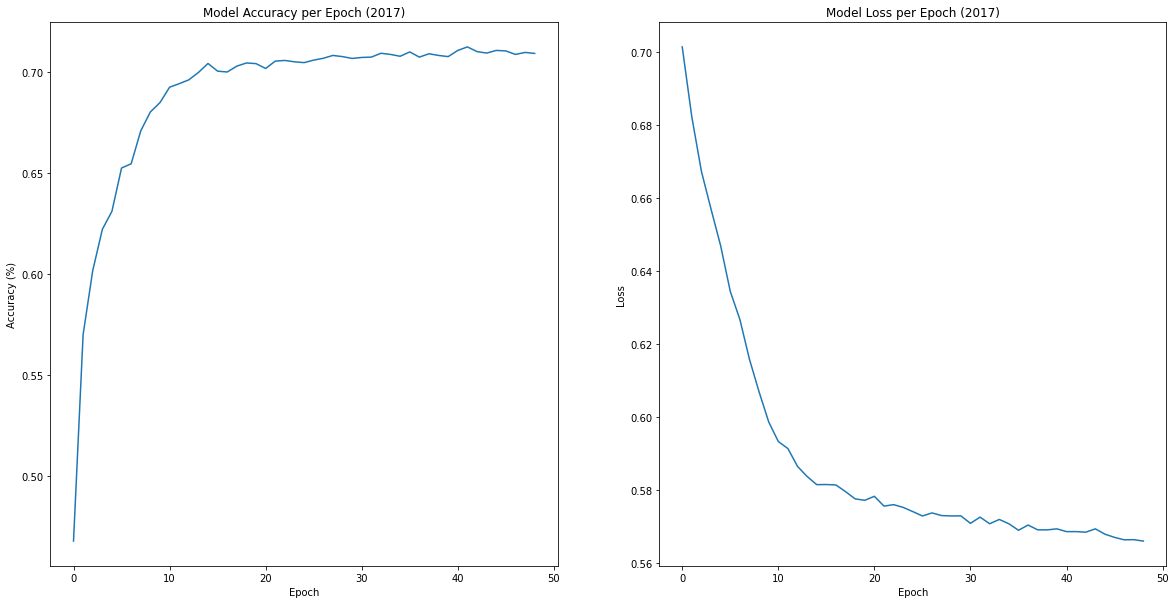

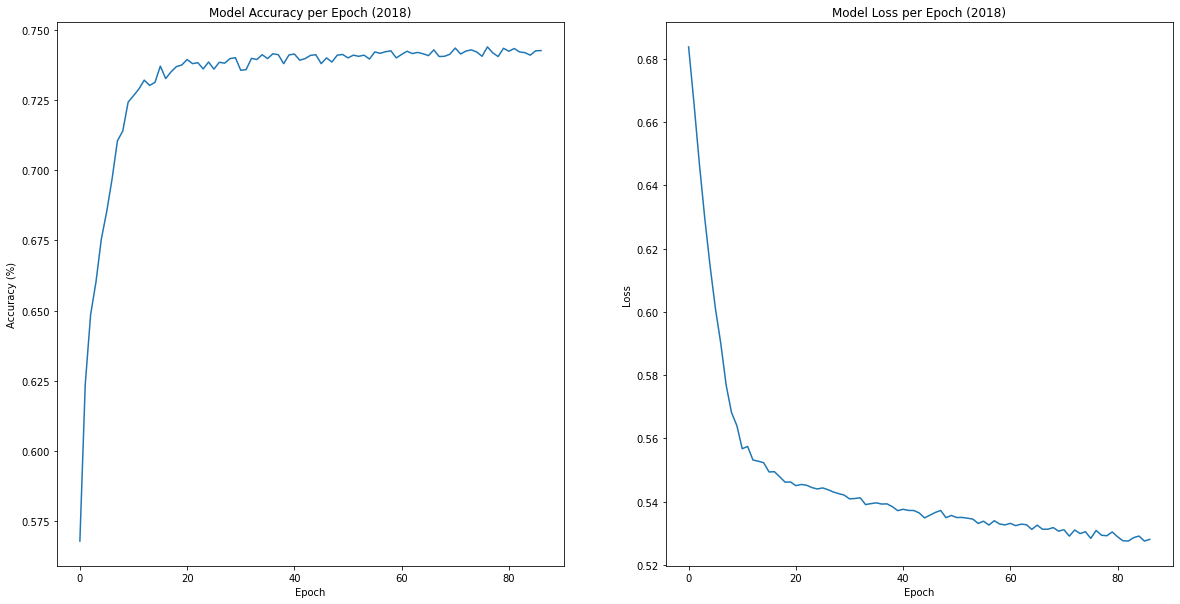

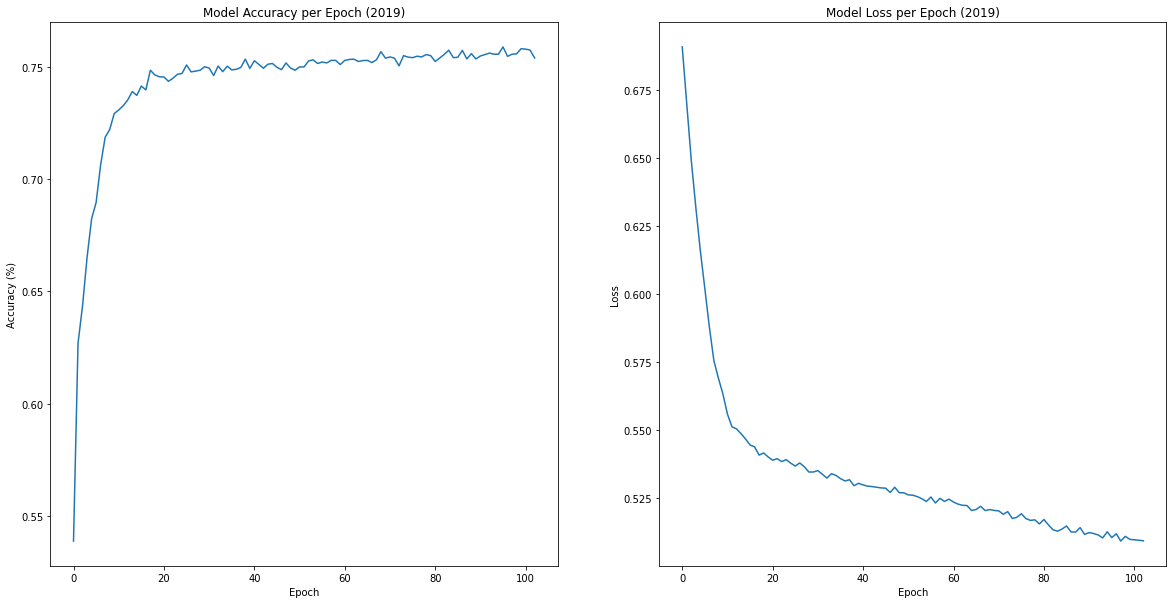

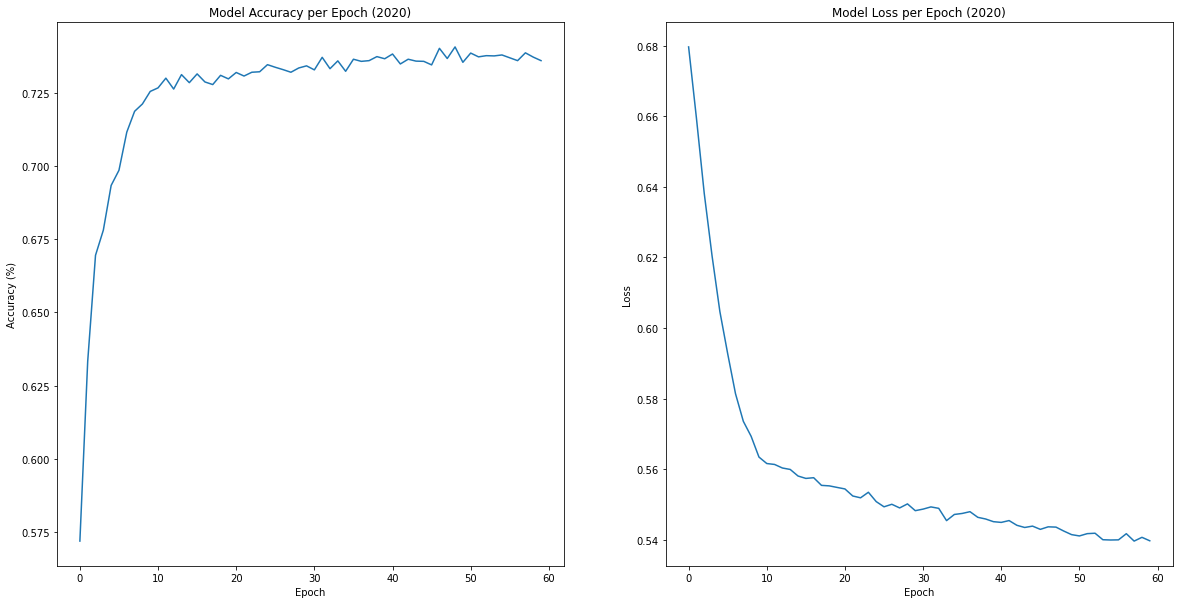

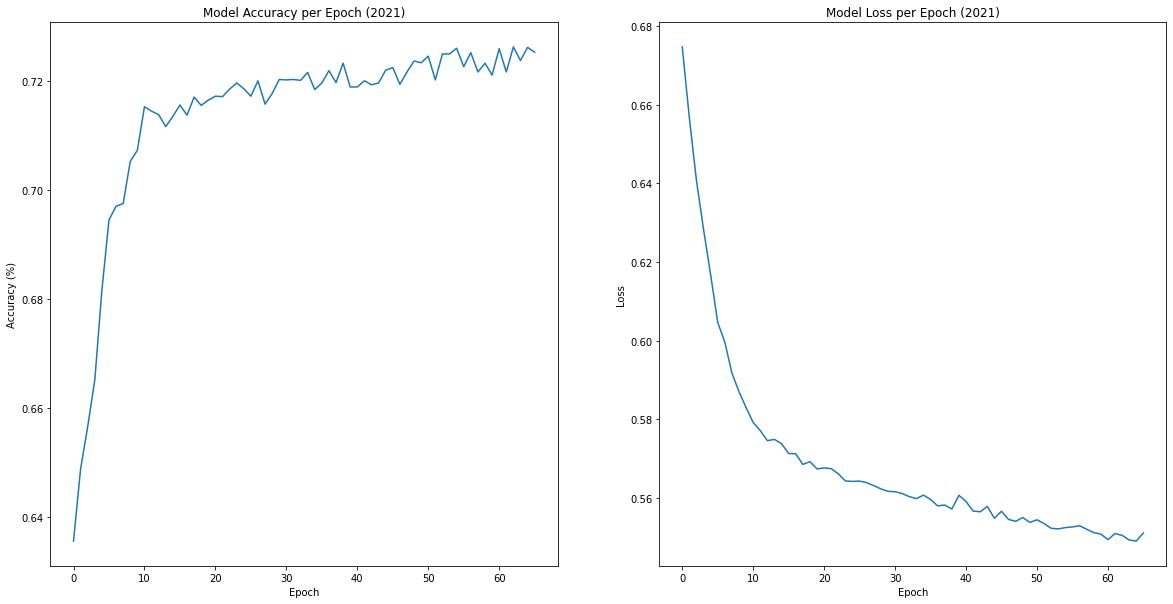

In [30]:
for k in hist_dict:
  fig = plt.figure(figsize = (20, 10))
  plt.subplot(121)
  plt.plot(range(len(hist_dict[k]['acc'])),hist_dict[k]['acc'])
  plt.title(f'Model Accuracy per Epoch ({k})')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(122)
  plt.plot(range(len(hist_dict[k]['loss'])), hist_dict[k]['loss'])
  plt.title(f'Model Loss per Epoch ({k})')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

We see here that our models during training are doing fairly well. Some of the graphs, like Model Accuracy per Epoch (2016) have oscillations at the top. This is an indication of overfitting, which we might be able to prevent by decreasing the learning rate.

###Loading Model and Making Predictions

Here we load our saved model for `test_year`, and perform predictions on data for this year 2021.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This puts the saved models in our drive.

In [32]:
import shutil 

model_path = '/content/drive/MyDrive/Capstone Project/Models'

for k in os.listdir():
  if k.startswith('saved-model-Intraday'):
    print(k)
    try:
      shutil.move(k, model_path)
    except:
      print('Model Already Exists')

saved-model-Intraday-240-3-LSTM-2018
Model Already Exists
saved-model-Intraday-240-3-LSTM-2013
Model Already Exists
saved-model-Intraday-240-3-LSTM-2019
Model Already Exists
saved-model-Intraday-240-3-LSTM-2015
Model Already Exists
saved-model-Intraday-240-3-LSTM-2021
Model Already Exists
saved-model-Intraday-240-3-LSTM-2016
Model Already Exists
saved-model-Intraday-240-3-LSTM-2017
Model Already Exists
saved-model-Intraday-240-3-LSTM-2020
Model Already Exists
saved-model-Intraday-240-3-LSTM-2014
Model Already Exists


Here we import model, now we need to make some predictions.

In [33]:
imported = tf.keras.models.load_model(model_path + '/saved-model-Intraday-240-3-LSTM-2021')

In [34]:
dates = list(set(test[:,0]))
predictions = {}
a = []
for day in dates:
        test_d = test[test[:,0]==day]
        test_d = reshaper(test_d[:,2:-2])
        predictions[day] = imported.predict(test_d)[:,1]

returns = simulate(test,predictions)
returns.to_csv(result_folder+'/avg_daily_rets-'+str(test_year)+'.csv')

# writes report
# includes: Mean, Sharpe, StDev
result_LSTM = Statistics(returns.sum(axis=1))
print('\nAverage returns prior to transaction charges')
result_LSTM.shortreport() 
    
#Write mode for our results text file
if test_year == 2013:
  file_mode = "w"
else:
  file_mode = "a"

with open(result_folder+"/avg_returns.txt", file_mode) as myfile:
    res = '-'*30 + '\n'
    res += str(test_year) + '\n'
    res += 'Mean = ' + str(result.mean()) + '\n'
    res += 'Sharpe = '+str(result.sharpe()) + '\n'
    res += '-'*30 + '\n'
    myfile.write(res)

Result :  Long     0.009157
Short    0.009902
dtype: float64

Average returns prior to transaction charges
Mean 		 0.019059197260217375
Standard dev 	 0.0076293161110240594
Sharpe ratio 	 39.032728509458046


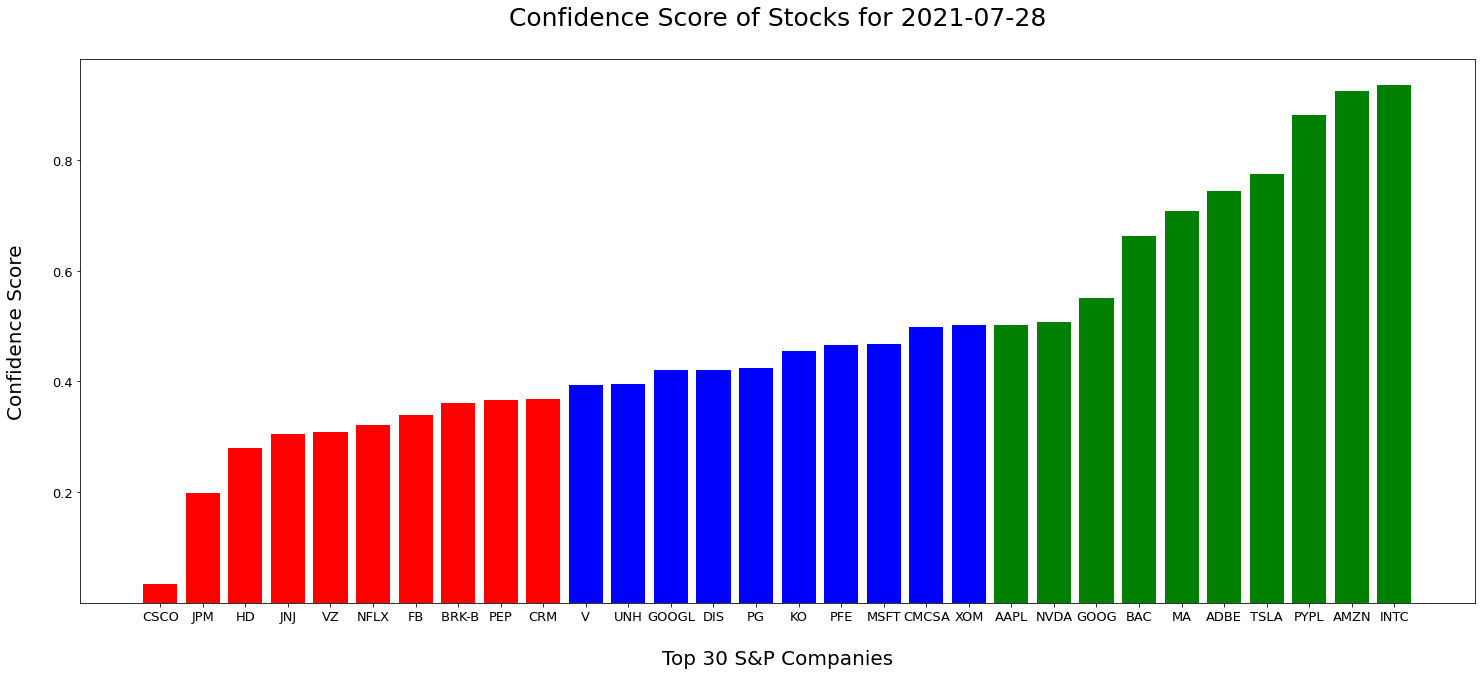

In [35]:
#Empty lists for predictions on the latest day.
new = []
new_index = []

#Configure plot
colors = ['red']*10 + ['blue' ] * 10 + ['green'] * 10 
fig = plt.subplots(figsize=(25,10))

#Find latest date
temp = []
for k in predictions:
  temp.append(k)

temp = sorted(temp)

#Extract and sort indexes for plotting
for j in predictions[temp[-1]].argsort():
  new.append(predictions[temp[-1]][j])
  new_index.append(sorted(index)[j])

plt.bar(new_index, new, color = colors)
plt.title('Confidence Score of Stocks for {}\n'.format(temp[-1]), fontsize=25)
plt.ylabel('Confidence Score\n', fontsize=20)
plt.xlabel('\nTop 30 S&P Companies', fontsize = 20)
plt.xticks(new_index, fontsize=13)
plt.yticks([0.2, 0.4, 0.6, 0.8], fontsize = 13)
plt.show()

These predictions are confidence levels on how an index will trend on a given day. The bottom values in red are the stocks that will likely underperform. The top 10 values in green are the most undervalued. We predict that the value will be higher than it actually is.

##RF Model


These functions will split and label our data in a similar fashion too.

In [36]:
def create_label(df_open,df_close,perc=[0.5,0.5]):
    if not np.all(df_close.iloc[:,0]==df_open.iloc[:,0]):
        print('Date Index issue')
        return
    perc = [0.]+list(np.cumsum(perc))
    label = (df_close.iloc[:,1:]/df_open.iloc[:,1:]-1).apply(
            lambda x: pd.qcut(x.rank(method='first'),perc,labels=False), axis=1)
    return label

In [37]:
def create_stock_data(df_close,df_open,st):
    st_data = pd.DataFrame([])
    st_data['Date'] = list(df_close['Date'])
    st_data['Name'] = [st]*len(st_data)
    
    daily_change = df_close[st]/df_open[st]-1
    m = list(range(1,20))+list(range(20,241,20))
    for k in m:
        st_data['IntraR'+str(k)] = daily_change.shift(k)
    for k in m:
        st_data['CloseR'+str(k)] = df_close[st].pct_change(k).shift(1)
    for k in m:
        st_data['OverNR'+str(k)] = df_open[st]/df_close[st].shift(k)-1
        
    st_data['R-future'] = daily_change 
    st_data['label'] = list(label[st]) 
    st_data['Month'] = list(df_close['Date'].str[:-3])
    st_data = st_data.dropna()
    
    trade_year = st_data['Month'].str[:4]
    st_data = st_data.drop(columns=['Month'])
    st_train_data = st_data[trade_year<str(test_year)]
    st_test_data = st_data[trade_year==str(test_year)]
    return st_train_data,st_test_data

This function will split identify our features and target, initialize our RF model, and make predictions. 

In [38]:
def trainer(train_data,test_data):
    random.seed(SEED)
    np.random.seed(SEED)
    
    train_x,train_y = train_data[:,2:-2],train_data[:,-1]
    train_y = train_y.astype('int')

    print('Started training')
    clf = RandomForestClassifier(n_estimators=1000, 
        max_depth=10, 
        random_state = SEED, 
        n_jobs=-1)
    clf.fit(train_x,train_y)
    print('Completed ',clf.score(train_x,train_y))

    dates = list(set(test_data[:,0]))
    predictions = {}
    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = test_d[:,2:-2] 
        predictions[day] = clf.predict_proba(test_d)[:,1]
  
    return predictions, clf

This function will perform a trading strategy that selects the top 10 and flop 10 stocks in the stock portfolio. The top 10 are the stocks with the most confidence to outperform. The flop 10 have the lowest confidence of outperforming. In other words, these stocks are predicted to not outperform its current trend.

In [39]:
#This is the validation step
def simulate(test_data,predictions):
    rets = pd.DataFrame([],columns=['Long','Short'])
    k = 10
    for day in sorted(predictions.keys()):
        preds = predictions[day]
        test_returns = test_data[test_data[:,0]==day][:,-2]
        top_preds = predictions[day].argsort()[-k:][::-1] 
        trans_long = test_returns[top_preds]
        worst_preds = predictions[day].argsort()[:k][::-1] 
        trans_short = -test_returns[worst_preds]
        rets.loc[day] = [np.mean(trans_long),np.mean(trans_short)] 
    return rets   

In [40]:
from sklearn.ensemble import RandomForestClassifier

SEED = 9
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.chdir('/content')

SP500_df = pd.read_csv('SPXconst.csv')
all_companies = list(set(SP500_df.values.flatten()))

constituents = {'-'.join(col.split('/')[::-1]):set(SP500_df[col].dropna()) 
                for col in SP500_df.columns}

constituents_train = {} 
for test_year in range(2013,2021):
    months = [str(t)+'-0'+str(m) if m<10 else str(t)+'-'+str(m) 
              for t in range(test_year-3,test_year) for m in range(1,13)]
    constituents_train[test_year] = [list(constituents[m]) for m in months]
    constituents_train[test_year] = set([i for sublist in constituents_train[test_year] 
                                         for i in sublist])
    


result_folder = 'results-Intraday-240-3-RF'
for directory in [result_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)

#Initialize model variable to save latest model after code block runs
model = None

for test_year in range(2013,2021):
    
    print('-'*40)
    print(test_year)
    print('-'*40)
    
    filename = 'Open-'+str(test_year-3)+'.csv'
    df_open = pd.read_csv(filename)
    filename = 'Close-'+str(test_year-3)+'.csv'
    df_close = pd.read_csv(filename)
    
    label = create_label(df_open,df_close)
    stock_names = sorted(list(constituents[str(test_year-1)+'-12']))
    train_data,test_data = [],[]
    
    start = time.time()
    for st in stock_names:
        st_train_data,st_test_data = create_stock_data(df_close,df_open,st)
        train_data.append(st_train_data)
        test_data.append(st_test_data)

    train_data = np.concatenate([x for x in train_data])
    test_data = np.concatenate([x for x in test_data])
    
    print('Created :',train_data.shape,test_data.shape,time.time()-start)
    
    predictions, model = trainer(train_data,test_data)
    returns = simulate(test_data,predictions)
    result = Statistics(returns.sum(axis=1))
    print('\nAverage returns prior to transaction charges')
    result.shortreport() 
    
    with open(result_folder+'/predictions-'+str(test_year)+'.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    returns.to_csv(result_folder+'/avg_daily_rets-'+str(test_year)+'.csv')

    #Write mode for our results text file
    if test_year == 2013:
      file_mode = "w"
    else:
      file_mode = "a"


    with open(result_folder+"/avg_returns.txt", file_mode) as myfile:
        res = '-'*30 + '\n' 
        res += str(test_year) + '\n'
        res += 'Mean = ' + str(result.mean()) + '\n'
        res += 'Sharpe = '+str(result.sharpe()) + '\n'
        res += '-'*30 + '\n'
        myfile.write(res)
        


----------------------------------------
2013
----------------------------------------
Created : (14242, 97) (7222, 97) 2.3578083515167236
Started training
Completed  0.8668726302485606

Average returns prior to transaction charges
Mean 		 0.013923795781150048
Standard dev 	 0.005320961548375076
Sharpe ratio 	 40.645107342294004
----------------------------------------
2014
----------------------------------------
Created : (14530, 97) (7308, 97) 2.4423398971557617
Started training
Completed  0.872401927047488

Average returns prior to transaction charges
Mean 		 0.013076782120713209
Standard dev 	 0.005885182715401728
Sharpe ratio 	 34.46369264824712
----------------------------------------
2015
----------------------------------------
Created : (14782, 97) (7308, 97) 2.3901402950286865
Started training
Completed  0.8715329454742254

Average returns prior to transaction charges
Mean 		 0.012159365350158964
Standard dev 	 0.005133668943487803
Sharpe ratio 	 36.671937870142024
---------

###Making 2021 predictions 

In [41]:
open_df = pd.read_csv('Open-2018.csv')
close_df = pd.read_csv('Close-2018.csv')
test_year = 2021

label = create_label(open_df,close_df)

In [42]:
train, test = [],[]

for s in index:
  st_train, st_test = create_stock_data(open_df, close_df ,s)
  train.append(st_train)
  test.append(st_test)

train = np.concatenate([x for x in train])
test = np.concatenate([x for x in test])

scalar_normalize(train,test)

predictions_rf, model_rf = trainer(train,test)
returns_rf = simulate(test,predictions_rf)
result_rf = Statistics(returns.sum(axis=1))
print('\nAverage returns prior to transaction charges')
result_rf.shortreport() 
    
with open(result_folder+'/predictions-'+str(test_year)+'.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
returns.to_csv(result_folder+'/avg_daily_rets-'+str(test_year)+'.csv')

#Write mode for our results text file
if test_year == 2013:
  file_mode = "w"
else:
  file_mode = "a"


with open(result_folder+"/avg_returns.txt", file_mode) as myfile:
    res = '-'*30 + '\n' 
    res += str(test_year) + '\n'
    res += 'Mean = ' + str(result.mean()) + '\n'
    res += 'Sharpe = '+str(result.sharpe()) + '\n'
    res += '-'*30 + '\n'
    myfile.write(res)

Started training
Completed  0.9116504854368932

Average returns prior to transaction charges
Mean 		 0.016979899728199677
Standard dev 	 0.010061335813364323
Sharpe ratio 	 26.317101859789926


Returns of LSTM model for 2021

In [43]:
result_LSTM.shortreport()

Mean 		 0.019059197260217375
Standard dev 	 0.0076293161110240594
Sharpe ratio 	 39.032728509458046


When running this simulation we had a mean return of 0.016979 and Sharpe ratio of 26.317 for the Random Forest Model. In the same simulation, our LSTM Model had a mean return of 0.01909 and Sharpe ratio of 39.05 for the year 2021. 

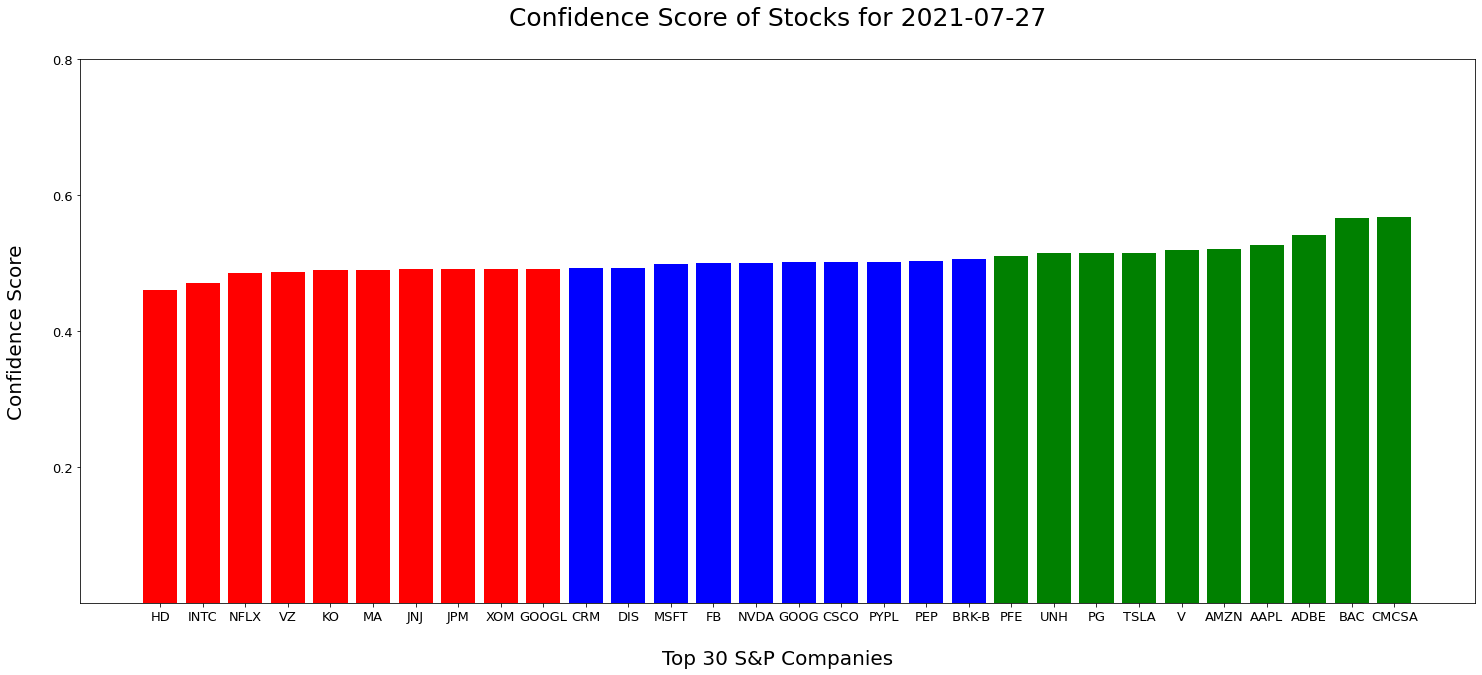

In [44]:
#Empty lists for predictions on the latest day.
new = []
new_index = []

#Configure plot
colors = ['red']*10 + ['blue' ] * 10 + ['green'] * 10 
fig = plt.subplots(figsize=(25,10))

#Find latest date
temp = []
for k in predictions_rf:
  temp.append(k)

temp = sorted(temp)

#Extract and sort indexes for plotting
for j in predictions_rf[temp[-3]].argsort():
  new.append(predictions_rf[temp[-3]][j])
  new_index.append(sorted(index)[j])

plt.bar(new_index, new, color = colors)
plt.title('Confidence Score of Stocks for {}\n'.format(temp[-3]), fontsize=25)
plt.ylabel('Confidence Score\n', fontsize=20)
plt.xlabel('\nTop 30 S&P Companies', fontsize = 20)
plt.xticks(new_index, fontsize=13)
plt.yticks([0.2, 0.4, 0.6, 0.8], fontsize = 13)
plt.show()

#Graphs

##RF and LSTM average returns graph

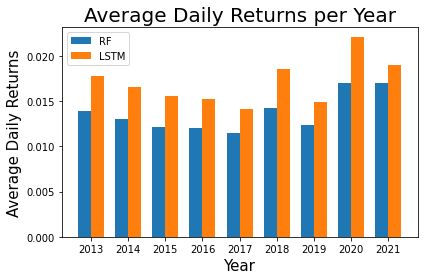

In [57]:
import matplotlib.pyplot as plt

# declare arrays to store average returns
avg_daily_retRF = []
avg_daily_retLSTM = []

# need year labels for graph
labels = range(2013,2022)
# width to offset both bars on tick marker
width = 0.35

for yr in range(2013,2022):
  df1 = pd.read_csv('/content/results-Intraday-240-3-RF/avg_daily_rets-'+str(yr)+'.csv')
  df2 = pd.read_csv('/content/results-Intraday-240-3-LSTM/avg_daily_rets-'+str(yr)+'.csv')
  avg_daily_retRF.append(np.mean(df1['Long'] + df1['Short']))
  avg_daily_retLSTM.append(np.mean(df2['Long'] + df2['Short']))

x = np.arange(len(labels))

fig,ax = plt.subplots()
RF = ax.bar(x-width/2,avg_daily_retRF, width, label = 'RF')
LSTM = ax.bar(x+width/2,avg_daily_retLSTM,width, label = 'LSTM')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Average Daily Returns',fontsize=15)
ax.set_title('Average Daily Returns per Year', fontsize=20)
ax.legend()

fig.tight_layout()
plt.show()

Here we see that our LSTM model outperforms RF in all years. 

In [46]:
diff = []
percent_improvement = []
for i, k in enumerate(avg_daily_retLSTM):
  diff.append(k - avg_daily_retRF[i])
  percent_improvement.append( (k - avg_daily_retRF[i]) / avg_daily_retRF[i] )
  
print(f'The average difference between models is {np.array(diff).mean() * 100}%')

print(f'Additionally, there is an improvement of {np.array(percent_improvement).mean()}')

The average difference between models is 0.35829161260383013%
Additionally, there is an improvement of 0.26723976205739597


##RF and LSTM Sharpe ratio graph

We have to parse through the `avg_returns.txt` file to extract the Sharpe ratio and other metric information for analysis.

In [47]:
def parse_avg_rets(file_path):
  file1 = open(file_path, 'r')

  splt = '\n'

  rets = file1.read().split(splt)

  mean = []
  sharpe = []
  year = []
  for k in rets:
    t = ''
    for char in k:
        if char.isdigit() or char == '.':
          t += char
    if k.startswith('2'):
      year.append(t)
    elif k.startswith('Mean'):
      mean.append(float(t))
    elif k.startswith('Sharpe'):
      sharpe.append(float(t))
    
  return mean, sharpe, year

  file1.close()

In [48]:
ret_file_LSTM = '/content/results-Intraday-240-3-LSTM/avg_returns.txt'

mean_LSTM, sharpe_LSTM, year_LSTM = parse_avg_rets(ret_file_LSTM)

In [49]:
ret_file_RF = '/content/results-Intraday-240-3-RF/avg_returns.txt'

mean_RF, sharpe_RF, year_RF = parse_avg_rets(ret_file_RF)

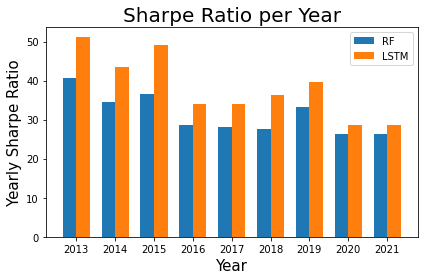

In [58]:
x = np.arange(len(year_LSTM))
fig,ax = plt.subplots()
RF = ax.bar(x-width/2,sharpe_RF, width, label = 'RF')
LSTM = ax.bar(x+width/2,sharpe_LSTM, width, label = 'LSTM')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Year',fontsize=15)
ax.set_ylabel('Yearly Sharpe Ratio',fontsize=15)
ax.set_title('Sharpe Ratio per Year', fontsize=20)
ax.legend()

fig.tight_layout()
plt.show()



Again, we see that our LSTM network is an improvement over the benchmark RF.

In [59]:
diff = []
for i, k in enumerate(sharpe_LSTM):
  diff.append(k - sharpe_RF[i])

print(f'The average difference between our LSTM and RF models is {np.array(diff).mean()}')

The average difference between our LSTM and RF models is 6.95988136954596


Plot opening and closing stock prices.

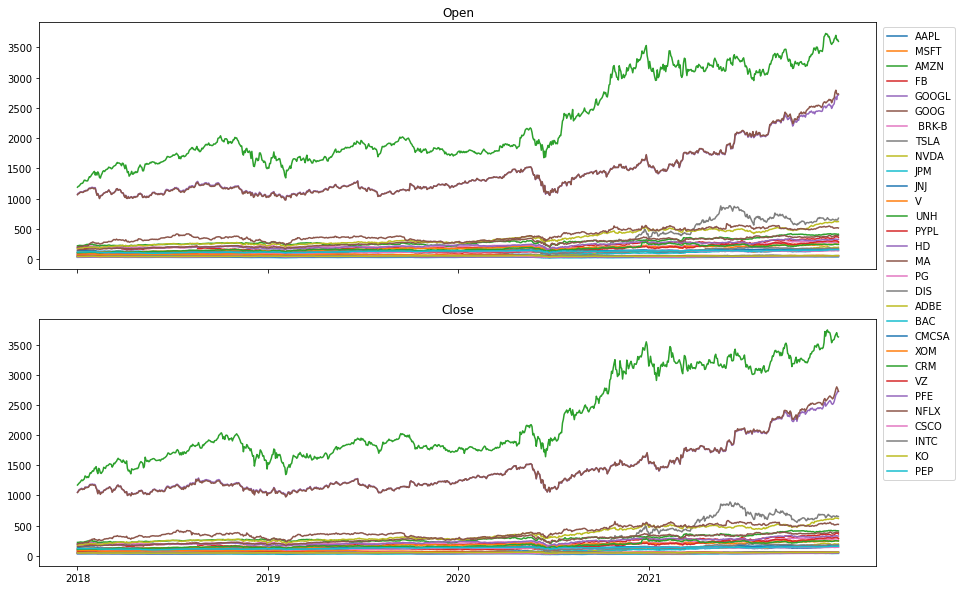

In [60]:
open_data = pd.read_csv('/content/Open-2018.csv')
close_data = pd.read_csv('/content/Close-2018.csv')

stocks = [x for x in open_data if x != 'Date']

split = range(1,4)
fig,(open_graph, close_graph) = plt.subplots(2,figsize=(15,10), sharex=True)
for stock in stocks:
  open_graph.plot(open_data['Date'],open_data[stock], label = stock)
  close_graph.plot(close_data['Date'],close_data[stock], label = stock)
  open_graph.set_xticks(np.arange(0,open_data['Date'].size,open_data['Date'].size/4))
  open_graph.set_xticklabels(['2018','2019','2020','2021'])

open_graph.set_title('Open')
close_graph.set_title('Close')
open_graph.legend(loc='upper right',bbox_to_anchor=(1.1, 1))

plt.show()




We can see that the bottom performers are very close. We can sort our data to take a closer look at the bottom 10 and top 10 companies and compare their overall open and closing prices.

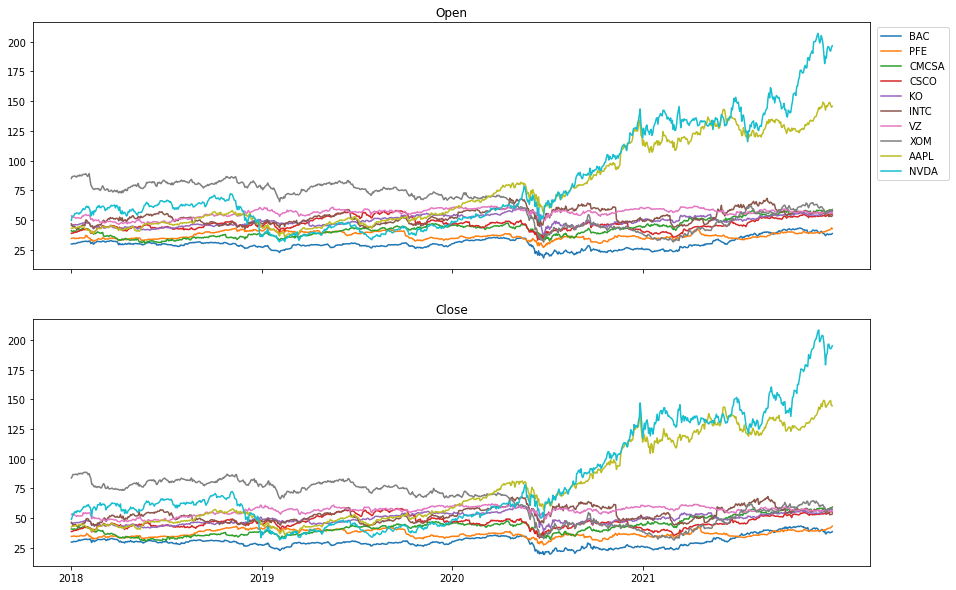

In [61]:
open_data_sorted=open_data.reindex(open_data.mean().sort_values().index,axis=1)
close_data_sorted=close_data.reindex(open_data.mean().sort_values().index,axis=1)

sorted_stocks = [x for x in open_data_sorted if x != 'Date']

split = range(1,4)
fig,(open_graph, close_graph) = plt.subplots(2,figsize=(15,10), sharex=True)
for stock in sorted_stocks[:10]:
  open_graph.plot(open_data['Date'],open_data_sorted[stock], label = stock)
  close_graph.plot(close_data['Date'],close_data_sorted[stock], label = stock)
  open_graph.set_xticks(np.arange(0,open_data['Date'].size,open_data['Date'].size/4))
  open_graph.set_xticklabels(['2018','2019','2020','2021'])

open_graph.set_title('Open')
close_graph.set_title('Close')
open_graph.legend(loc='upper right',bbox_to_anchor=(1.1, 1))

plt.show()

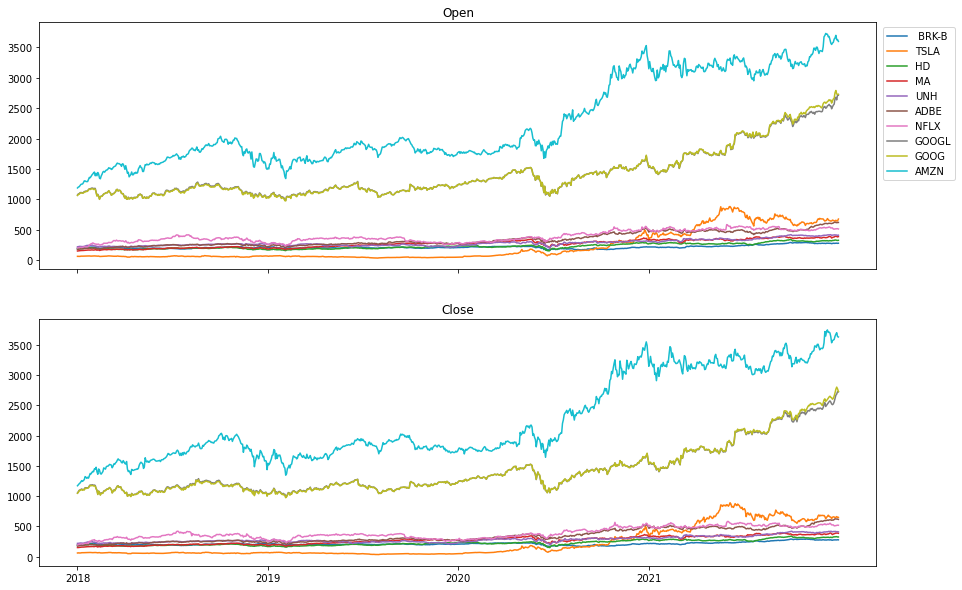

In [62]:
fig,(open_graph, close_graph) = plt.subplots(2,figsize=(15,10), sharex=True)
for stock in sorted_stocks[-10:]:
  open_graph.plot(open_data['Date'],open_data_sorted[stock], label = stock)
  close_graph.plot(close_data['Date'],close_data_sorted[stock], label = stock)
  open_graph.set_xticks(np.arange(0,open_data['Date'].size,open_data['Date'].size/4))
  open_graph.set_xticklabels(['2018','2019','2020','2021'])

open_graph.set_title('Open')
close_graph.set_title('Close')
open_graph.legend(loc='upper right',bbox_to_anchor=(1.1, 1))

plt.show()